# Dimensionality Reduction and Clustering of UK Biobank Asthma Patients

This notebook does the following:

* Reads in a sample of UKBB Asthma patients
* Performs dimensionality reduction on UKBB Asthma Patients with PCA and finds the optimal number of principal components
* Performs dimensionality reduction on UKBB Asthma patients wit tSNE, using the otpimal number of principal components
* Performs kMeans clustering to find any clusters of UKBB asthma patients



In [2]:
import pandas as pd 
import numpy as np
%matplotlib inline
from matplotlib import rc
rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=False)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,6)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import decomposition
from sklearn import manifold
from sklearn.cluster import KMeans 

# Step 1: Read in UKBB asthma patients and subselect data

Fields in UKBB phenotype data come in three types:

1) 'QUANTITY' fields - these fields are continuous variables. Integers and Decimal numbers
2) 'CATEGORY' fields - these fields are not continuous. There are a limited number of integers which label specfic category values
3) 'BIN' fields - these are binary fields. They only have two possible values. They only label a field as being 'TRUE' or 'FALSE' 

For summary statistics and finding the most correlated variables, we only selected 'QUANTITY' fields.  For dimensionality reduction for further clustering, it's not so clear whether we have to select only 'QUANTITY' fields.

In [3]:
#Read in 5K sample
#asthma_df=pd.read_csv("ukbb_asthma_sample_5k.csv",sep='\t')
asthma_df=pd.read_csv("ukbb_asthma_sample_5k_new.csv",sep='\t')

/opt/wakari/anaconda/envs/default/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3,2931,2943) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Select columns to filter on
cols = [col for col in asthma_df.columns if 'HES_p' not in col and 'PC' not in col]

In [5]:
asthma_df=asthma_df[cols].drop('Unnamed: 0',axis=1)

In [6]:
#select only 'QUANTITY' fields
asthma_df_quant=asthma_df.loc[:, asthma_df.columns.str.contains('QUANT|age|BMI')].fillna(0.0)
#select only fields with 10 or more unique values
for col in asthma_df_quant.columns:
    if len(asthma_df_quant[col].unique()) < 20 :
        asthma_df_quant.drop(col,inplace=True,axis=1)

        
#select only 'QUANTITY' and "CATEGORY" fields
asthma_df_quant_cat=asthma_df.loc[:, asthma_df.columns.str.contains('QUANT|age|BMI|CAT|sex')].fillna(0.0)
asthma_df_quant_cat=asthma_df_quant_cat.drop(columns=['f_22182_0_0_f_CAT_HLA_imputation_values_and_quality'])
#selects all features. 

asthma_df_all=asthma_df.loc[:,~asthma_df.columns.str.contains('ID|random|chip|asthma')].fillna(0.0)
asthma_df_all=asthma_df_all.drop(columns=['f_22182_0_0_f_CAT_HLA_imputation_values_and_quality'])


In [7]:
asthma_df_quant.shape

(5000, 651)

# Step 2: Reduce dimensions with PCA

The next step is to perform PCA to reduce the dimensions in the data set. PCA is straightforward with Python. It's not straightforward to identify the ideal number of Principal Components to use and which data to include. We have three data frames in this notebook:

* asthma_df_quant - this data frame only has 'QUANTITY' fields. This is exaclty the same as the exploratory analysis phase finding summary statistics and correlated/uncorrelated variables.
* asthma_df_quant_cat - this data frame has both 'QUANTITY' fields and 'CATEGORY' fields. This totals about 1500 features
* asthma_df_all - this data frame has everything - 'QUANTITY', 'CATEGORY', and 'BINARY' fields.


In this step we have to:

* Perform PCA in two configurations: Two principal components and the optimal number of principal components
* We need to perform this PCA on all three data frames listed above. 



## Data Scaling
Before dimensionality reduction and further clustering with kMeans, data has to be scaled. The standard scaler scales the data to an average value of 0 and a unit variance of 1. This is appropriate for the 'QUANTITY' features. We can't use the standard scaler for the other features, so we do 'min/max' scaling, which scales the data in the range from 0 to 1.


In [8]:
#Scale the quantity features only
data_quant=StandardScaler().fit_transform(asthma_df_quant.values)
#Scale the quantity AND CATEGORY features
data_quant_cat=StandardScaler().fit_transform(asthma_df_quant_cat.applymap(lambda x: float(x)).values)
#Scale ALL THE features
data_all=StandardScaler().fit_transform(asthma_df_all.applymap(lambda x:float(x)).values)


## PCA 

/opt/wakari/anaconda/envs/default/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


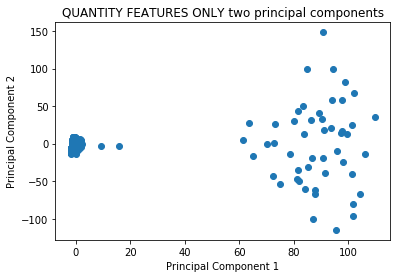

In [9]:
pca_2d = decomposition.PCA(n_components=2)
pca_quant_2d=pca_2d.fit_transform(data_quant)

plt.scatter(pca_quant_2d[:,0],pca_quant_2d[:,1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('QUANTITY FEATURES ONLY two principal components')
plt.show()

## Finding the optimal number of principal components for each three data frames

It's easier to talk about in person, but the best way to determine the optimal number of principal components is to plot the 'cummulative eigenvalue fraction' vs the number of eigenvalues. The code to do this is below. The example code is for 500 principal components - this is way too many. I'll explain why below:


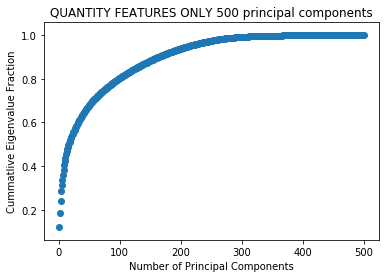

In [10]:
# PCA for 500 components
pca_500d = decomposition.PCA(n_components=500)
pca_quant_500d=pca_500d.fit_transform(data_quant)

# Calculate the cummalative eigenvalue fraction
eigen_fraction_500d=np.cumsum(pca_500d.explained_variance_)/(np.sum(pca_500d.explained_variance_))
#Plot the Results
plt.scatter(range(1,len(pca_500d.explained_variance_)+1),eigen_fraction_500d)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cummatlive Eigenvalue Fraction')
plt.title('QUANTITY FEATURES ONLY 500 principal components')
plt.show()

## Do you see how the plot is flat for most of it? It means 500 is way too many principal components. The optimal number of Principal components is when the above plot only starts to get flat. Copy and paste the code below to find the optimal number of Principal Components for all three data frames:

* Quantitative Features Only
* Quantitative + Categorical Features
* All Features

#### Hint

This is not as hard as it looks. You can reduce the number of principal components in the above plot (to say 150 or so) and pick out the optimal number of components by eye. 

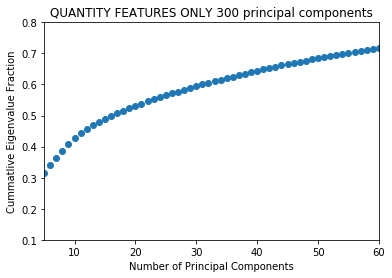

In [11]:
# PCA for 300 components

pca_300d = decomposition.PCA(n_components=300)
pca_quant_300d=pca_300d.fit_transform(data_quant)

# Calculate the cummalative eigenvalue fraction
eigen_fraction_300d=np.cumsum(pca_300d.explained_variance_)/(np.sum(pca_300d.explained_variance_))
#Plot the Results
plt.scatter(range(1,len(pca_300d.explained_variance_)+1),eigen_fraction_300d)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cummatlive Eigenvalue Fraction')
plt.xlim(5,60)
plt.ylim(0.1,0.8)
plt.title('QUANTITY FEATURES ONLY 300 principal components')
plt.show()

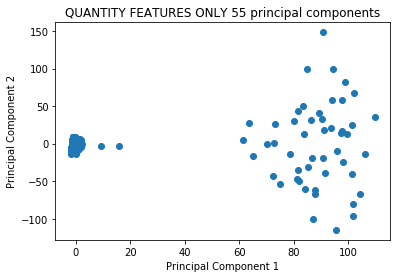

In [12]:
pca_55d = decomposition.PCA(n_components=55)
pca_quant_55d=pca_55d.fit_transform(data_quant)

plt.scatter(pca_quant_55d[:,0],pca_quant_55d[:,1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('QUANTITY FEATURES ONLY 55 principal components')
plt.show()

# Step 3: Dimensionality Reduction with tSNE

This part is straightforward. You will have to run the same code below and replace the number of dimensions with the optimal number of principal components you found above. You will have to do so again for all three data frames

In [13]:
'''tsne_2d = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,
                     learning_rate=300, n_iter=400)
    #tsne = manifold.TSNE(n_components=2, init='pca')
tsne_quant_2d=tsne_2d.fit_transform(data_quant)

plt.scatter(tsne_quant_2d[:,0],tsne_quant_2d[:,1])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('QUANTITY FEATURES ONLY tSNE with two components')
plt.show()
'''


"tsne_2d = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,\n                     learning_rate=300, n_iter=400)\n    #tsne = manifold.TSNE(n_components=2, init='pca')\ntsne_quant_2d=tsne_2d.fit_transform(data_quant)\n\nplt.scatter(tsne_quant_2d[:,0],tsne_quant_2d[:,1])\n\nplt.xlabel('Dimension 1')\nplt.ylabel('Dimension 2')\nplt.title('QUANTITY FEATURES ONLY tSNE with two components')\nplt.show()\n"

In [14]:
"""tsne_2d = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,
                     learning_rate=300, n_iter=400)
    #tsne = manifold.TSNE(n_components=2, init='pca')
tsne_quant_2d=tsne_2d.fit_transform(pca_quant_55d)

plt.scatter(tsne_quant_2d[:,0],tsne_quant_2d[:,1])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('QUANTITY FEATURES ONLY tSNE with two components')
plt.show()
"""

"tsne_2d = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,\n                     learning_rate=300, n_iter=400)\n    #tsne = manifold.TSNE(n_components=2, init='pca')\ntsne_quant_2d=tsne_2d.fit_transform(pca_quant_55d)\n\nplt.scatter(tsne_quant_2d[:,0],tsne_quant_2d[:,1])\n\nplt.xlabel('Dimension 1')\nplt.ylabel('Dimension 2')\nplt.title('QUANTITY FEATURES ONLY tSNE with two components')\nplt.show()\n"

# Step 4 - kMeans Clustering

We will have to do kMeans clustering on the data frame with quantitative features only, on the PCA transformed data. We will do kMeans on two different inputs:

* Two principal components 
* The optimal number of principal components (55)


## 2 principal component kMeans

From the PCA plots above, it looks like there are three clusters, possibly 4. A tSNE visualization on the PCA output would give us a better idea how many clusters there are likely to be. To perform kMeans clustering, you must perform the following steps:

* Run kMeans with the parameters n_init=15 and max_iter=400 on the 2-dimensional PCA output to find 3 clusters. Look at the documentation in http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html and https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
* Visualize the resulsting clusters on the 2-dimensional PCA scatter plot above. We want to just reproduce that plot and color the points with which cluster they belong to. Cell #4 in https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html demonstrates how to do this
* We next have to optimize the number of clusters. There are many ways to do this, but using the Silhouette Score to select the best number of clusters is probably the most direct and the fastest: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html and http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score Basically, we want the number of clusters such that the silhouette score (a measure of cluster separation) is as close to 1.0 as possible. Start with 2 clusters, Don't go over 8 clusters. 

## Optimal number (55) principal components

Repeat the above steps, but with 55 principal components. You can't visualize 55 dimensions of course, so just plot the first two principal components of the 55. 

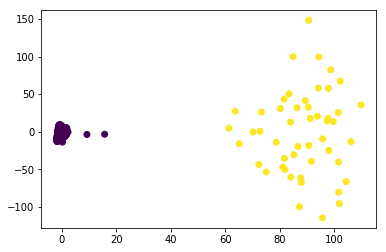

In [15]:
X = pca_quant_55d
kmeans = KMeans(n_clusters=2, n_init=15, max_iter=400).fit(X)
y_pred = kmeans.predict(X)

plt.scatter(X[:,0], X[:,1], c=y_pred)

In [16]:
len(y_pred)

5000

0.8078242601209306


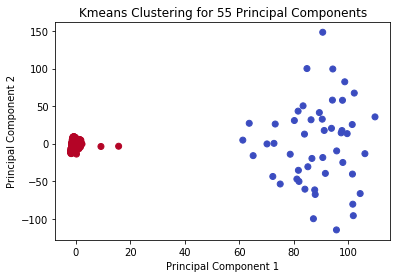

In [17]:
X = pca_quant_55d
kmeans = KMeans(n_clusters=2, n_init=15, max_iter=400)
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_labels = kmeans.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print(silhouette_avg)
plt.scatter(X[:,0], X[:,1], c=cluster_labels, cmap="coolwarm")
plt.title("Kmeans Clustering for 55 Principal Components")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
#plt.savefig('kmeans_55d_scatterplot.png')

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth

X = pca_quant_55d
n=2
#clusterer = KMeans(n_clusters=n, random_state=1
clusterer = AgglomerativeClustering(n_clusters=n,linkage='average',affinity='l1')

cluster_labels = clusterer.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print(silhouette_avg)
plt.scatter(X[:,0], X[:,1], c=cluster_labels)
plt.show()

# Step 5 - find which features contribute the most to PCA. 

In [18]:
## which variables change the data the most/ have the highest variance 

/local/apps/wakari/anaconda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


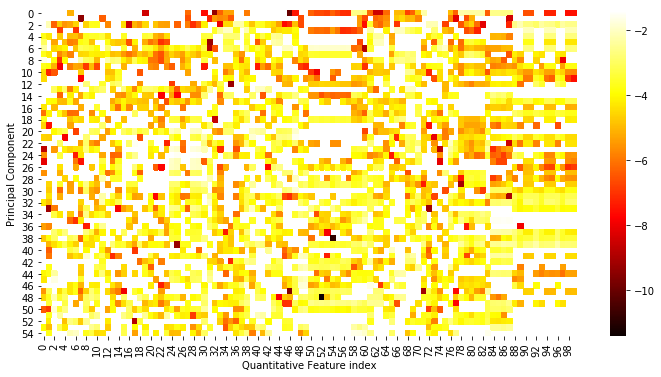

In [19]:
import seaborn as sns
plt.rcParams['figure.figsize']=(12,6)

sns.heatmap(np.log(pca_55d.inverse_transform(np.eye(pca_quant_55d.shape[1])))[:,0:100], cmap="hot", cbar=True)
plt.ylabel('Principal Component')
plt.xlabel('Quantitative Feature index')
plt.show()

In [20]:
## pale colors are most important 

### The above plot shows a heat map of feature importances. Because we have over 600 quantitative features, I only show 100. There are 55 principal components. The more yellow the heatmap is, the more important the feature is. Let's average over the principal components to get the most important features

In [21]:
log_importances=np.log(pca_55d.inverse_transform(np.eye(pca_quant_55d.shape[1])))

/local/apps/wakari/anaconda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


In [22]:
mean_log_importances=np.apply_along_axis(np.mean,0,np.nan_to_num(log_importances))
print(len(mean_log_importances))

651


In [23]:
mean_log_importances_df=pd.DataFrame(data=mean_log_importances,columns=['importance'])

In [24]:
mean_log_importances_df=mean_log_importances_df.reset_index()
print(mean_log_importances_df.head(15))

    index  importance
0       0   -2.202245
1       1   -2.503591
2       2   -1.489553
3       3   -2.233309
4       4   -1.510685
5       5   -2.145830
6       6   -2.276684
7       7   -2.866062
8       8   -1.816430
9       9   -2.127903
10     10   -2.339577
11     11   -1.717517
12     12   -1.889577
13     13   -2.126357
14     14   -2.351862


### The numpy array above is an array of importances, of length 638. They map back to the original data frame:

In [25]:
print(asthma_df_quant.columns[0],asthma_df_quant.columns[637])

('age', 'specialRequest_QUANT_number_of_hospitalizing_copd_exacerbation_caseOnly_SPIROMETRY_residualizedRelated')


In [26]:
## every entry in array, can get variabe name 

# Find the ten most important features to start, including their names, to focus on. 

In [27]:
## labels 0-638: have value associated. 
## output array as csv file -- find 10 highest values in the array and associated array index number 

np.savetxt("Asthma Important Features.csv", mean_log_importances_df, delimiter=",")

In [28]:
asthma_df_important_features = mean_log_importances_df.sort_values(by="importance", ascending=False)
print(asthma_df_important_features.head(15))

     index  importance
559    559   -1.203593
350    350   -1.284105
542    542   -1.356178
509    509   -1.438513
223    223   -1.471740
67      67   -1.475051
530    530   -1.480573
287    287   -1.481605
2        2   -1.489553
251    251   -1.491783
428    428   -1.499381
424    424   -1.506952
246    246   -1.507320
4        4   -1.510685
617    617   -1.516582


# Step 6: ANOVA of the ten most important features between the two clusters

In [29]:
# Add the group label to the data frame:
asthma_df_quant['Cluster Label']=y_pred
asthma_df_quant['Cluster Label']=asthma_df_quant['Cluster Label'].apply(str).apply(lambda x: x.replace('0','A')).apply(lambda x: x.replace('1','B'))

In [30]:
asthma_df_quant.shape

(5000, 652)

### adding the cluster labels allows you to visualize box plots broken down by cluster easily. For example, for age:

In [31]:
## include box plots for top 10 variables 

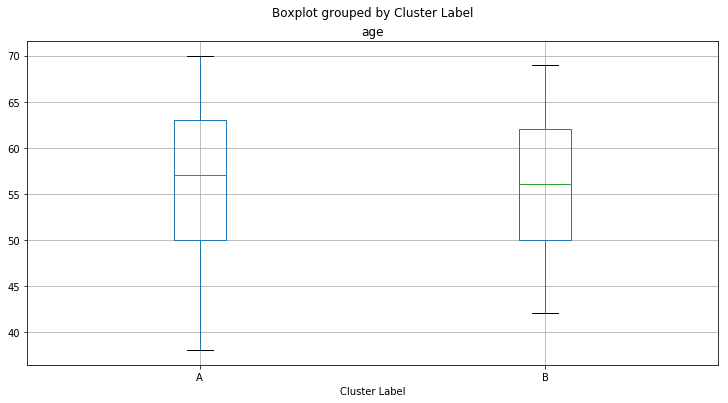

In [32]:
asthma_df_quant.boxplot(asthma_df_quant.columns[0],by='Cluster Label')

In [33]:
v = asthma_df_important_features['index'].values[0]

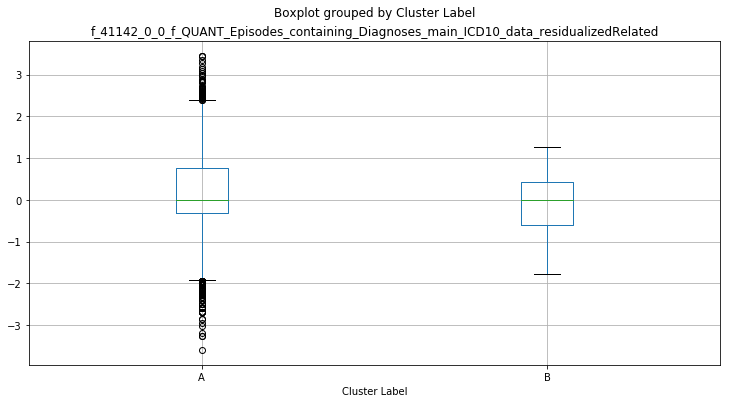

In [34]:
asthma_df_quant.boxplot(asthma_df_quant.columns[v],by='Cluster Label')

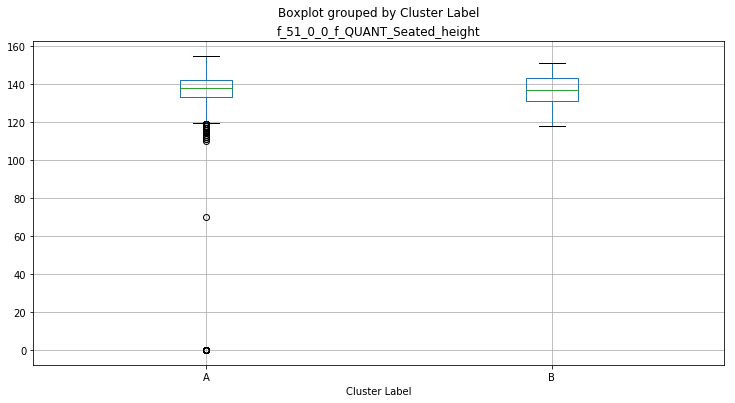

In [35]:
asthma_df_quant.boxplot(asthma_df_quant.columns[237],by='Cluster Label')

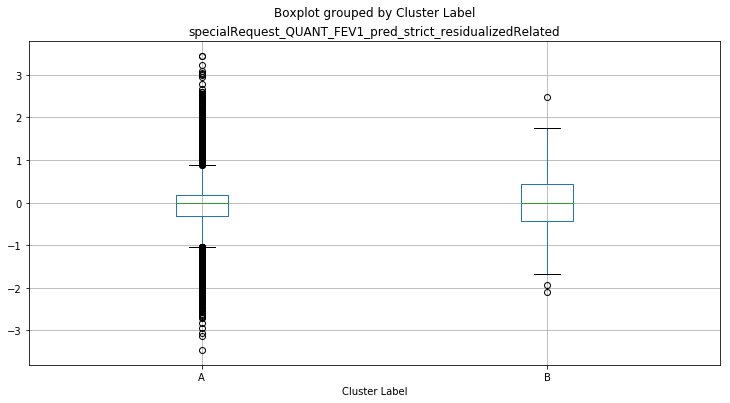

In [36]:
asthma_df_quant.boxplot(asthma_df_quant.columns[632],by='Cluster Label')

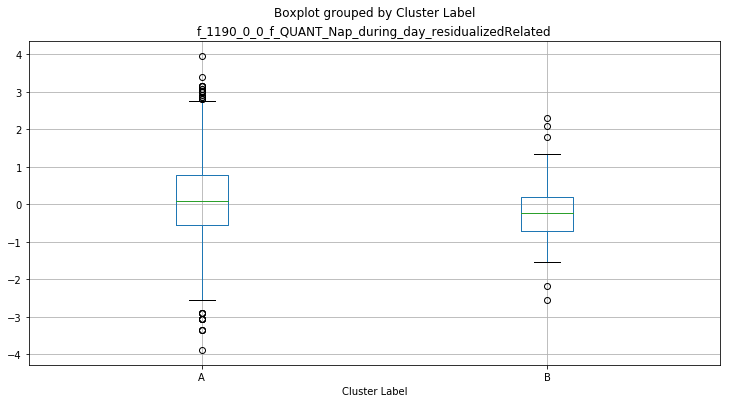

In [37]:
asthma_df_quant.boxplot(asthma_df_quant.columns[332],by='Cluster Label')

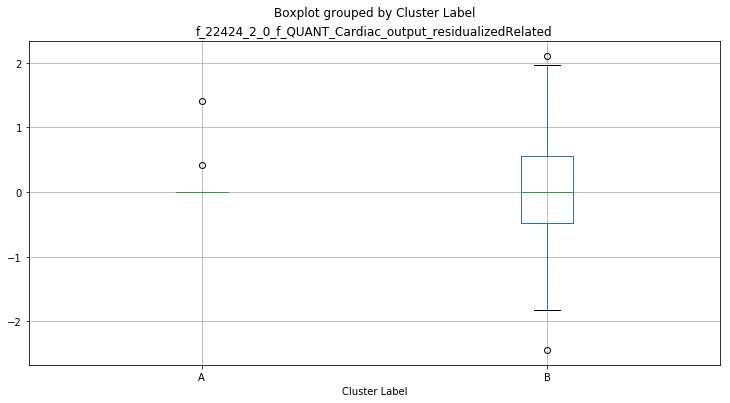

In [38]:
asthma_df_quant.boxplot(asthma_df_quant.columns[413],by='Cluster Label')

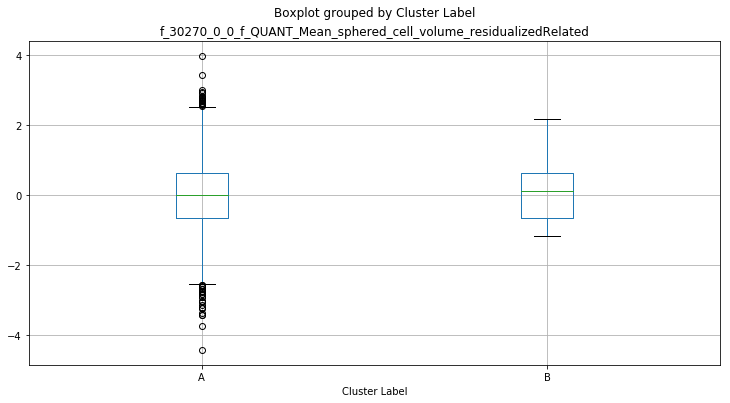

In [39]:
asthma_df_quant.boxplot(asthma_df_quant.columns[549],by='Cluster Label')

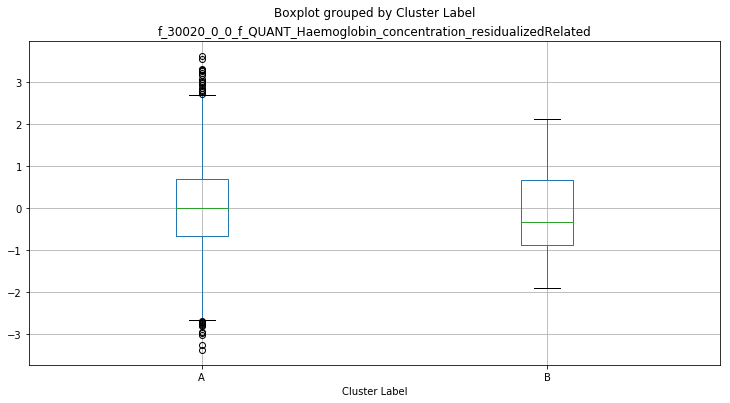

In [40]:
asthma_df_quant.boxplot(asthma_df_quant.columns[524],by='Cluster Label')

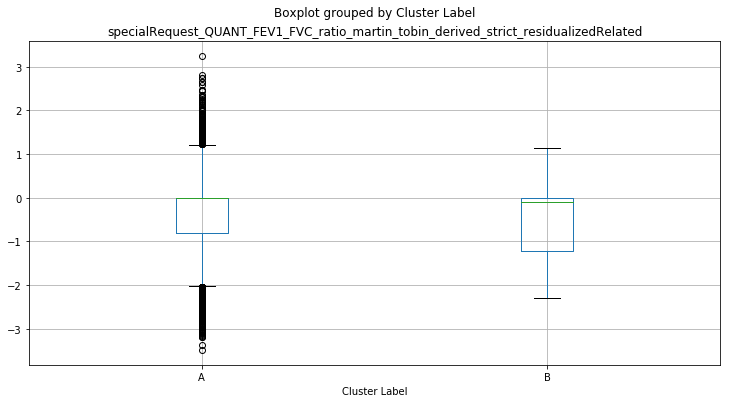

In [41]:
asthma_df_quant.boxplot(asthma_df_quant.columns[621],by='Cluster Label')

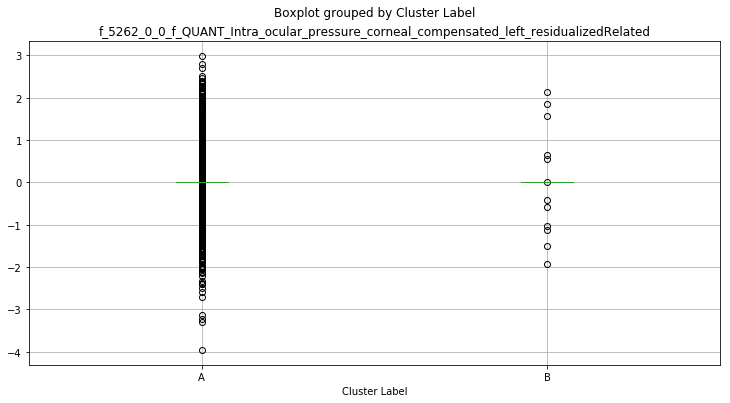

In [42]:
asthma_df_quant.boxplot(asthma_df_quant.columns[380],by='Cluster Label')

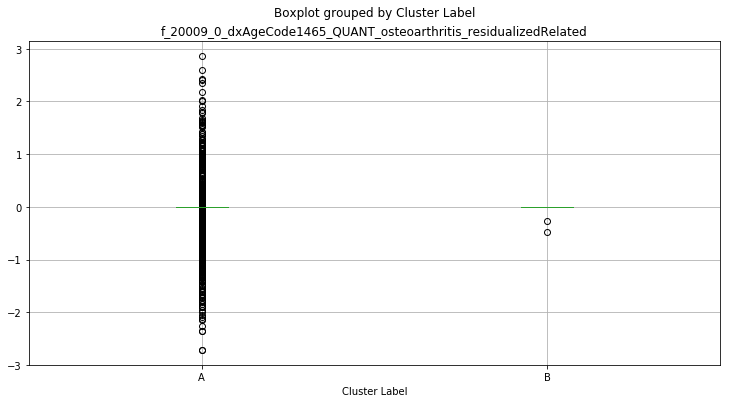

In [43]:
asthma_df_quant.boxplot(asthma_df_quant.columns[590],by='Cluster Label')

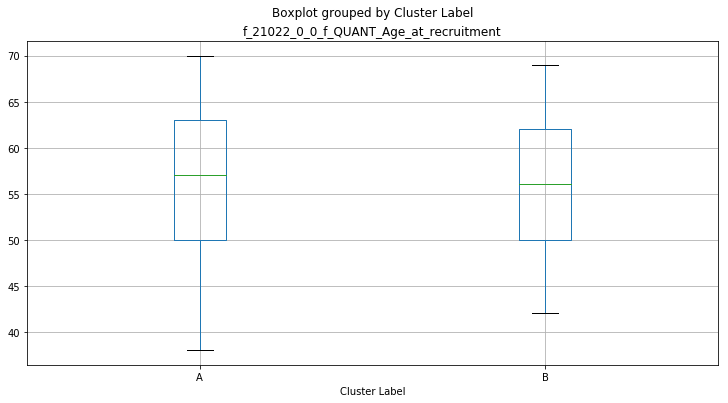

In [44]:
asthma_df_quant.boxplot(asthma_df_quant.columns[238],by='Cluster Label')

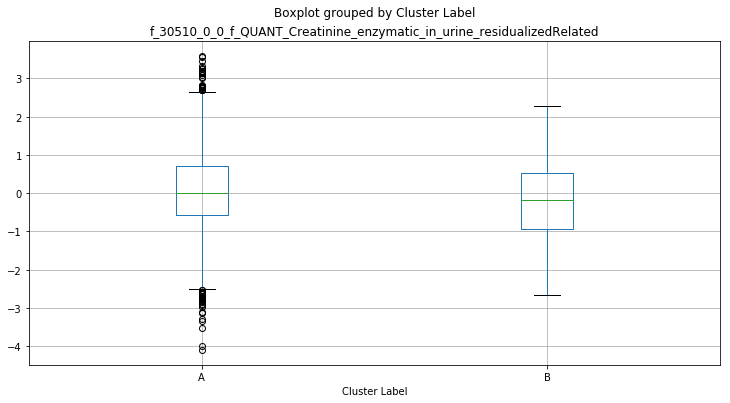

In [45]:
asthma_df_quant.boxplot(asthma_df_quant.columns[554],by='Cluster Label')

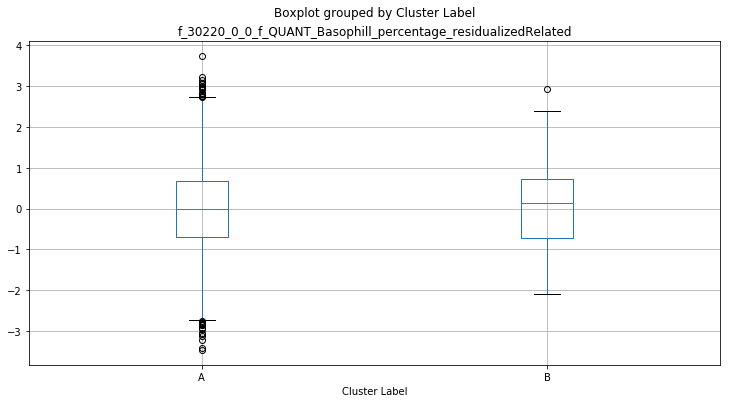

In [46]:
asthma_df_quant.boxplot(asthma_df_quant.columns[544],by='Cluster Label')

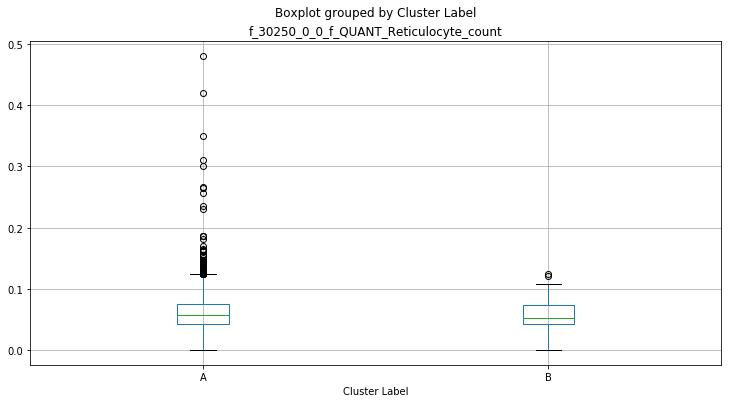

In [47]:
asthma_df_quant.boxplot(asthma_df_quant.columns[214],by='Cluster Label')

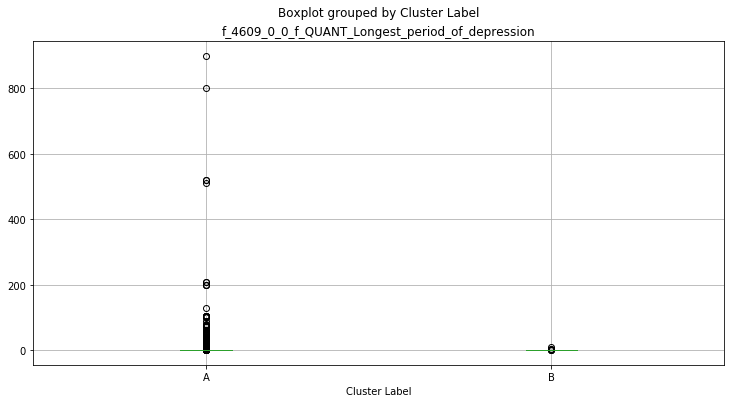

In [48]:
asthma_df_quant.boxplot(asthma_df_quant.columns[24],by='Cluster Label')

### which means the Data is not clustering by age. 

1) Visualize the data in box plots for all ten most important features
2) Run ANOVA on the ten most important features above to derive p-values. Good resources for ANOVA in Python include: https://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/ (first section with SciPy only) 

and

https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.f_oneway.html



# ANOVA - analyzes groups of data (group A vs B) to quantify how different they are 
## do each variable separately - 15 different ANOVA's
## lower the better p-value. we define the cutoff ( < 0.05)

In [49]:
asthma_df_quant_group1 = asthma_df_quant[asthma_df_quant['Cluster Label'].str.contains('A')]

asthma_df_quant_group2 = asthma_df_quant[asthma_df_quant['Cluster Label'].str.contains('B')]

In [50]:
[asthma_df_quant.columns[381]]


['f_5263_0_0_f_QUANT_Intra_ocular_pressure_Goldmann_correlated_left_residualizedRelated']

In [51]:
import scipy.stats as stats

feature = asthma_df_quant.columns[381]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))
## if pvalue < 0.05:

   

ANOVA Statistic 1.0545316316602493 and p-value 0.3045154103459558


In [52]:
feature = asthma_df_quant.columns[237]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.026157686723799128 and p-value 0.871522353308028


In [53]:
feature = asthma_df_quant.columns[632]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.21512325907984603 and p-value 0.642801340072308


In [54]:
feature = asthma_df_quant.columns[332]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 3.095257507827505 and p-value 0.07858190533656287


In [55]:
[asthma_df_quant.columns[413]]

['f_22424_2_0_f_QUANT_Cardiac_output_residualizedRelated']

In [56]:
feature = asthma_df_quant.columns[413]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.0026808141148451 and p-value 0.9587087870298916


In [57]:
feature = asthma_df_quant.columns[549]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 1.5217500140461304 and p-value 0.21741286426580023


In [58]:
feature = asthma_df_quant.columns[524]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 1.2414640036777327 and p-value 0.2652426681568481


In [59]:
feature = asthma_df_quant.columns[621]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.6397224383248215 and p-value 0.4238493358657355


In [60]:
[asthma_df_quant.columns[380]]

['f_5262_0_0_f_QUANT_Intra_ocular_pressure_corneal_compensated_left_residualizedRelated']

In [61]:
feature = asthma_df_quant.columns[380]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.07843223597387183 and p-value 0.7794449357104845


In [62]:
[asthma_df_quant.columns[590]]

['f_20009_0_dxAgeCode1465_QUANT_osteoarthritis_residualizedRelated']

In [63]:
feature = asthma_df_quant.columns[590]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.023620104489890287 and p-value 0.8778616871116094


In [64]:
feature = asthma_df_quant.columns[238]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.14581377895157566 and p-value 0.702584631630065


In [65]:
feature = asthma_df_quant.columns[554]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 3.536016118173133 and p-value 0.060107632563207


In [66]:
feature = asthma_df_quant.columns[544]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.05742579790842043 and p-value 0.8106216570145974


In [67]:
feature = asthma_df_quant.columns[214]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.13090731149372184 and p-value 0.7175084512136609


In [68]:
feature = asthma_df_quant.columns[24]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.553800374409879 and p-value 0.4568039926169415


In [69]:
asthma_df.columns

Index([u'FID', u'IID', u'RGC_ID', u'random_normal', u'random_binary', u'sex',
       u'chip', u'age', u'BMI', u'asthma',
       ...
       u'f_40019_0_p_D40_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_male_genital_organs',
       u'f_40019_0_p_D41_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_urinary_organs',
       u'f_40019_0_p_D42_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_meninges',
       u'f_40019_0_p_D43_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_brain_and_CNS',
       u'f_40019_0_p_D44_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_endocrine_glands',
       u'f_40019_0_p_D45_CAT_Polycythaemia_vera',
       u'f_40019_0_p_D46_CAT_Myelodysplastic_syndromes',
       u'f_40019_0_p_D47_CAT_Other_neoplasms_of_uncertain_behaviour_of_lymphoid_haematopoietic',
       u'f_40019_0_p_D48_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_other_sites',
       u'f_40019_0_p_O01_CAT_Hydatidiform_mole'],
      dtype='object', length=5172)

In [70]:
asthma_df_2=pd.read_csv("ukbb_asthma_sample_5k_new.csv",sep='\t')

In [71]:
for x in asthma_df_2.columns :
    if 'asthma' in x:
        print x

asthma
f_3786_0_0_f_QUANT_Age_asthma_diagnosed
f_22147_0_0_f_QUANT_Age_asthma_diagnosed_by_doctor
f_20009_0_dxAgeCode1111_QUANT_asthma
f_3786_0_0_f_QUANT_Age_asthma_diagnosed_residualizedRelated
f_22147_0_0_f_QUANT_Age_asthma_diagnosed_by_doctor_residualizedRelated
f_20009_0_dxAgeCode1111_QUANT_asthma_residualizedRelated
specialRequest_QUANT_type_of_asthma_exacerbation
specialRequest_QUANT_asthma_hospital_exacerbations_raw
specialRequest_QUANT_asthma_hospital_exacerbations_annual_rate
specialRequest_QUANT_asthma_HES_based_age_of_onset
specialRequest_QUANT_asthma_HES_or_NI_based_age_of_onset_youngest
f_22127_0_0_f_BIN_Doctor_diagnosed_asthma
f_22167_0_0_f_BIN_Recent_medication_for_asthma
f_20002_0_dxCode1111_BIN_asthma
HES_p_J46_BIN_Status_asthmaticus
HES_primary_p_J46_BIN_Status_asthmaticus
map2way_NI_code1111_BIN_asthma
specialRequest_BIN_NI_pediatric_asthma_under16yo
specialRequest_BIN_NI_adult_only_asthma_over16yo


In [72]:
asthma_df_2['f_22127_0_0_f_BIN_Doctor_diagnosed_asthma'].value_counts()

1.0    1194
0.0     158
Name: f_22127_0_0_f_BIN_Doctor_diagnosed_asthma, dtype: int64

In [73]:
print('hello')

hello


In [81]:
p_values=[]
features=list(asthma_df_quant_group1.columns.values[:-1])
anova_dict=dict()

for feature in asthma_df_quant_group1.columns.values[:-1]:
    (statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    p_values.append(pvalue)
anova_dict['feature']=features
anova_dict['pvalue']=p_values
anova_df=pd.DataFrame.from_dict(anova_dict)

In [105]:
anova_df=anova_df.sort_values(by='pvalue')
threshold=0.05
anova_df_significant=anova_df.loc[(anova_df.pvalue < threshold) & (anova_df.pvalue > 0)].sort_values(by='pvalue')

In [115]:
anova_df_significant.tail(50)

,feature,pvalue
275,f_20151_0_0_f_QUANT_Forced_vital_capacity_FVC_...,0.001767
243,f_3062_0_f_QUANT_FVC_maximumValue_strict,0.001767
247,f_3064_0_f_QUANT_PEF_maximumValue_strict,0.002033
574,f_47_f_QUANT_grip_strength_maximumValue_residu...,0.002155
575,f_47_46_QUANT_grip_strength_maximumValue_resid...,0.002160
280,specialRequest_QUANT_FEV1_ever_smoked_only_strict,0.003899
288,specialRequest_QUANT_FEV1_percent_pred_strict,0.004136
573,f_46_f_QUANT_grip_strength_maximumValue_residu...,0.004491
465,f_23248_2_0_f_QUANT_Android_total_mass_residua...,0.005032
379,f_5257_0_0_f_QUANT_Corneal_resistance_factor_r...,0.005108


In [119]:
anova_df_significant[anova_df_significant['feature'].str.contains('FEV|FVC')].shape

(24, 2)

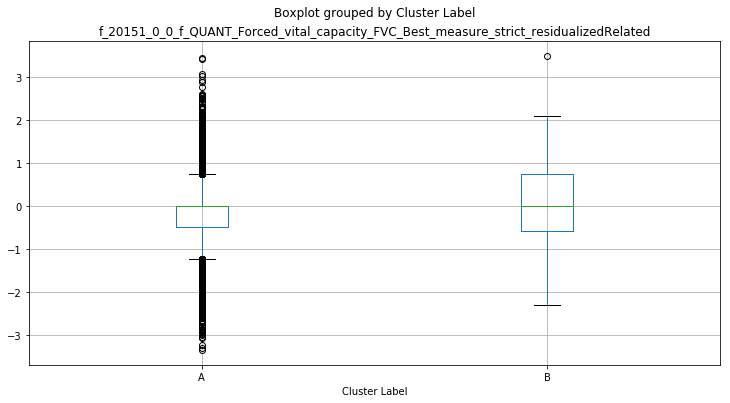

In [117]:
asthma_df_quant.boxplot(asthma_df_quant.columns[601],by='Cluster Label')

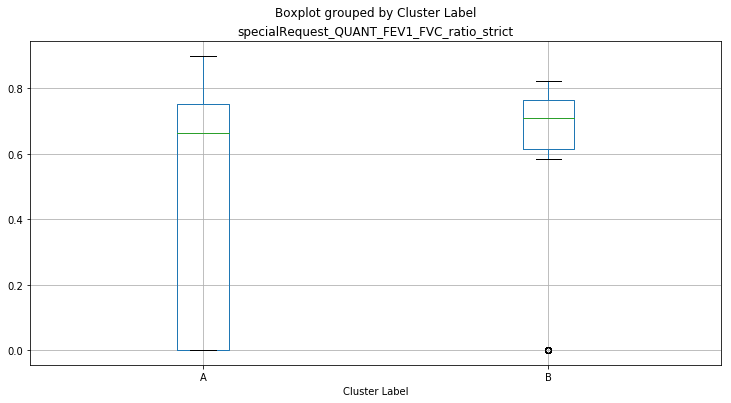

In [120]:
asthma_df_quant.boxplot(asthma_df_quant.columns[270],by='Cluster Label')